In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import plotly.express as px
import orca
import plotly.graph_objects as go
from scipy import stats
import plotly.figure_factory as ff
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.callbacks import EarlyStopping
%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [3]:
# read data for yahoo stock data
stock = 'AAPL'
start = '2000-01-01' 
end = '2020-12-01'
Data = pdr.get_data_yahoo(stock, start, end)
Data = Data.sort_values(by = ['Date'])

In [4]:
# Display first 5 rows and data shape
display(Data.head())
display(Data.shape)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.855168
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.783068
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.794528
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.725771
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.760149


(5263, 6)

In [5]:
# Check for nan values
Data.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [6]:
# General stats for TESLA stock
Data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5263.000000,5263.000000,5263.000000,5263.000000,5.263000e+03,5263.000000
mean,18.483761,18.091581,18.288782,18.294883,4.461571e+08,17.163891
std,23.125953,22.571547,22.849964,22.860386,3.918215e+08,22.547481
min,0.235536,0.227143,0.231964,0.234286,2.019780e+07,0.200465
25%,1.361607,1.327857,1.343929,1.344286,1.781824e+08,1.150232
50%,9.219286,8.921785,9.110357,9.065000,3.341184e+08,7.756426
75%,27.758750,27.191251,27.478749,27.441251,5.936350e+08,25.310430
max,137.979996,130.529999,137.589996,134.179993,7.421641e+09,133.948898


In [7]:
# Return Data columns
Data.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [8]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns:
    x[i] = x[i]/x[i][0]
  return x

In [26]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show("png")

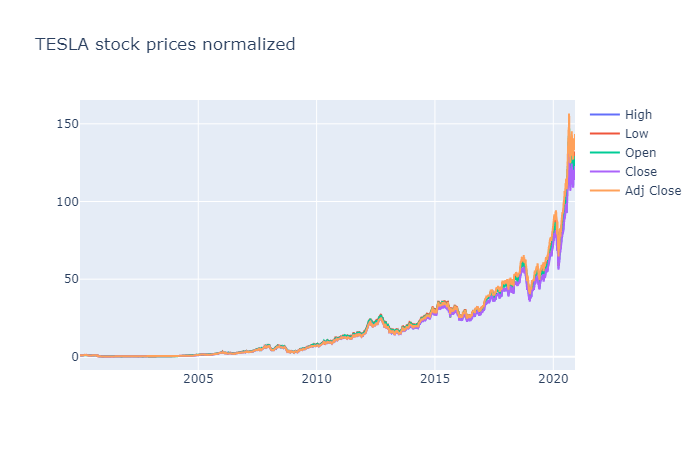

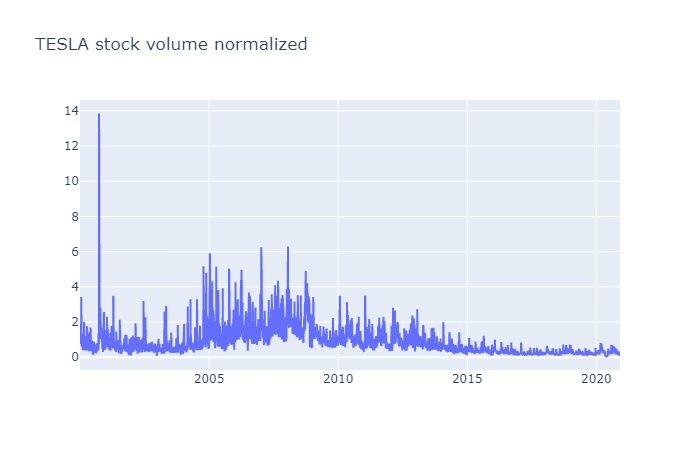

In [27]:
# plot interactive chart for stocks data before normalization
interactive_plot(normalize(Data.drop(columns=['Volume'])), 'TESLA stock prices normalized')
interactive_plot(normalize(Data[['Volume']]), 'TESLA stock volume normalized')

In [11]:
# Function to return the input/output (target) data for AI/ML Model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def training_window(data,look_back):
    df = data.copy()
    for i in range(1,look_back+1):
        df['Close(J-'+str(i)+')'] = df['Close'].shift(i)
    df['Target'] = df[['Close']].shift(-1)
    df = df[look_back:-1]
    return df

In [12]:
look_back = 6
Supervised_data = training_window(Data[['Close']], look_back)
Supervised_data

,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,
2000-01-11,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442,0.778460
2000-01-12,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.863839
2000-01-13,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.896763
2000-01-14,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928013
2000-01-18,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.951451
...,...,...,...,...,...,...,...,...
2020-11-23,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,119.260002,115.169998
2020-11-24,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,116.029999
2020-11-25,116.029999,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,116.589996


In [13]:
# Tarin test split
frac_train = 0.7
Split = int(frac_train*Supervised_data.shape[0])
train_df = Supervised_data[:Split]
test_df = Supervised_data[Split:]
display(train_df)
display(test_df)

,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,
2000-01-11,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442,0.778460
2000-01-12,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.863839
2000-01-13,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.896763
2000-01-14,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928013
2000-01-18,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.951451
...,...,...,...,...,...,...,...,...
2014-08-20,25.142500,25.132500,24.790001,24.495001,24.375000,24.309999,23.992500,25.145000
2014-08-21,25.145000,25.142500,25.132500,24.790001,24.495001,24.375000,24.309999,25.330000
2014-08-22,25.330000,25.145000,25.142500,25.132500,24.790001,24.495001,24.375000,25.385000


,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,
2014-08-27,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500,25.562500
2014-08-28,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.625000
2014-08-29,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.825001
2014-09-02,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,24.735001
2014-09-03,24.735001,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,24.530001
...,...,...,...,...,...,...,...,...
2020-11-23,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,119.260002,115.169998
2020-11-24,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,116.029999
2020-11-25,116.029999,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,116.589996


In [14]:
# Scale the data and divide it into variable X and traget y
# Note that we will devide data into train and test before scaling to avoid data linkage
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train_df)
test = sc.fit_transform(test_df)
X_train = train[:,:-1]
y_train = train[:,-1:]
X_test = test[:,:-1]
y_test = test[:,-1:]
print('X train shape is {} and y train shape is {}'.format(X_train.shape,y_train.shape))
print('X test shape is {} and y test shape is {}'.format(X_test.shape,y_test.shape))

X train shape is (3679, 7) and y train shape is (3679, 1)
X test shape is (1577, 7) and y test shape is (1577, 1)


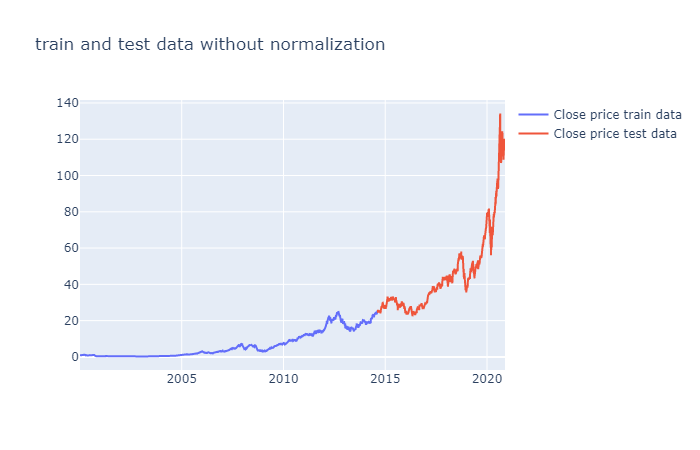

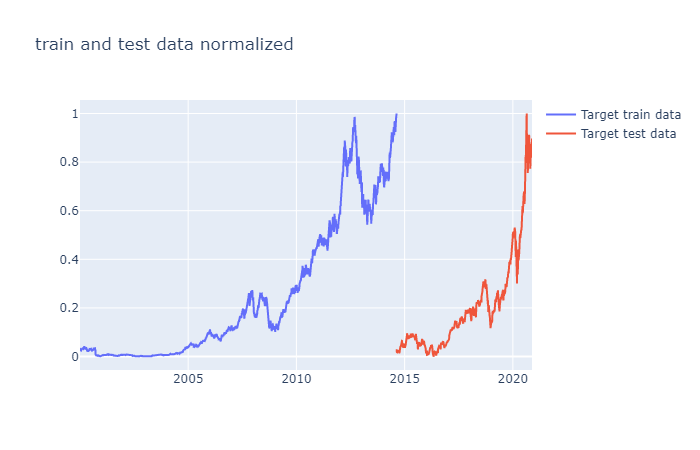

In [15]:
# Plot train data and test data without normalization 
fig = px.line(title = 'train and test data without normalization')
fig.add_scatter(x = Data.index[:Split], y = train_df['Close'],mode='lines', name = 'Close price train data')
fig.add_scatter(x = Data.index[Split:], y = test_df['Close'],mode='lines', name = 'Close price test data')
fig.show("png")
# Plot train data and test data normalized 
fig = px.line(title = 'train and test data normalized')
fig.add_scatter(x = Data.index[:Split], y = y_train[:,0],mode='lines', name = 'Target train data')
fig.add_scatter(x = Data.index[Split:], y = y_test[:,0],mode='lines', name = 'Target test data')
fig.show("png")

In [16]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((3679, 7, 1), (1577, 7, 1))

In [17]:
from keras.regularizers import l2
# Create the model
inputs = keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.001))(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

model = keras.Model(inputs=inputs, outputs= outputs)
model.compile(optimizer = 'adam', loss='mse')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 150)            180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________

In [18]:
# Train the model and save validation loss split in train
n_epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=64, validation_split=0.2)

Train on 2943 samples, validate on 736 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
2943/2943 [==============================] - 5s 2ms/sample - loss: 1.6664 - val_loss: 0.7129
Epoch 2/200
2943/2943 [==============================] - 3s 939us/sample - loss: 0.4618 - val_loss: 0.3159
Epoch 3/200
2943/2943 [==============================] - 3s 955us/sample - loss: 0.2684 - val_loss: 0.2365
Epoch 4/200
2943/2943 [==============================] - 3s 932us/sample - loss: 0.2195 - val_loss: 0.2056
Epoch 5/200
2943/2943 [==============================] - 3s 964us/sample - loss: 0.1943 - val_loss: 0.1843
Epoch 6/200
2943/2943 [==============================] - 3s 949us/sample - loss: 0.1743 - val_loss: 0.1654
Epoch 7/200
2943/2943 [==============================] - 3s 959us/sample - loss: 0.1565 - val_loss: 0.1484
Epoch 8/200
2943/2943 [==============================] - 3s 1ms/sample - loss: 0.1401 - val_loss: 0.1330
Epoch 9

2943/2943 [==============================] - 2s 734us/sample - loss: 7.9260e-05 - val_loss: 0.0010
Epoch 72/200
2943/2943 [==============================] - 2s 738us/sample - loss: 7.9908e-05 - val_loss: 0.0011
Epoch 73/200
2943/2943 [==============================] - 2s 753us/sample - loss: 7.4826e-05 - val_loss: 0.0013
Epoch 74/200
2943/2943 [==============================] - 2s 741us/sample - loss: 7.4921e-05 - val_loss: 6.4977e-04
Epoch 75/200
2943/2943 [==============================] - 2s 736us/sample - loss: 1.1894e-04 - val_loss: 0.0014
Epoch 76/200
2943/2943 [==============================] - 2s 734us/sample - loss: 8.9454e-05 - val_loss: 9.4914e-04
Epoch 77/200
2943/2943 [==============================] - 2s 740us/sample - loss: 8.1275e-05 - val_loss: 0.0028
Epoch 78/200
2943/2943 [==============================] - 2s 773us/sample - loss: 9.9876e-05 - val_loss: 0.0017
Epoch 79/200
2943/2943 [==============================] - 2s 741us/sample - loss: 1.0439e-04 - val_loss: 0.00

2943/2943 [==============================] - 2s 742us/sample - loss: 7.1723e-05 - val_loss: 0.0045
Epoch 144/200
2943/2943 [==============================] - 2s 760us/sample - loss: 7.6891e-05 - val_loss: 0.0034
Epoch 145/200
2943/2943 [==============================] - 2s 792us/sample - loss: 1.1168e-04 - val_loss: 0.0058
Epoch 146/200
2943/2943 [==============================] - 2s 769us/sample - loss: 5.9837e-05 - val_loss: 0.0051
Epoch 147/200
2943/2943 [==============================] - 3s 861us/sample - loss: 7.3328e-05 - val_loss: 0.0047
Epoch 148/200
2943/2943 [==============================] - 2s 830us/sample - loss: 9.7781e-05 - val_loss: 0.0057
Epoch 149/200
2943/2943 [==============================] - 2s 806us/sample - loss: 6.7181e-05 - val_loss: 0.0054
Epoch 150/200
2943/2943 [==============================] - 2s 742us/sample - loss: 7.0803e-05 - val_loss: 0.0070
Epoch 151/200
2943/2943 [==============================] - 2s 726us/sample - loss: 8.3646e-05 - val_loss: 0.00

In [19]:
# Plot Model Loss progress During Training'
interactive_plot(pd.DataFrame(history.history), 'Model Loss progress During Training')

In [20]:
# from the loss plot we can see that the validation loss is less volatile between 60 and 80
# we'll choose 70 epochs for training
# Train the model with validation_data
n_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test,y_test))

Train on 3679 samples, validate on 1577 samples
Epoch 1/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 7.0567e-04 - val_loss: 5.7642e-04
Epoch 2/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.7597e-04 - val_loss: 2.7776e-04
Epoch 3/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.9156e-04 - val_loss: 2.9405e-04
Epoch 4/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.0633e-04 - val_loss: 3.6636e-04
Epoch 5/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.2122e-04 - val_loss: 2.6864e-04
Epoch 6/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.7349e-04 - val_loss: 3.8938e-04
Epoch 7/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.2939e-04 - val_loss: 4.9940e-04
Epoch 8/50
3679/3679 [==============================] - 4s 1ms/sample - loss: 3.3058e-04 - val_loss: 4.8564e-04
Epoch 9/50
3679/3679 [==============================] - 

In [21]:
# Inverse scale predictions and add predictions to supervised data 
#test_df = test_df.drop(columns=['Target'])
predictions = model.predict(X_test)
Predictions_df = pd.DataFrame(X_test[:,:,0], columns = test_df.columns[:-1], index=test_df.index)
Predictions_df['Predictions'] = predictions
Predictions_df = pd.DataFrame(sc.inverse_transform(Predictions_df),columns=Predictions_df.columns, index=Predictions_df.index)
Predictions_df['Target'] = test_df['Target']
Predictions_df = Predictions_df[['Target','Predictions']]
Predictions_df

,Target,Predictions
Date,,
2014-08-27,25.562500,25.678875
2014-08-28,25.625000,25.747632
2014-08-29,25.825001,25.818015
2014-09-02,24.735001,25.915939
2014-09-03,24.530001,25.756608
...,...,...
2020-11-23,115.169998,115.257378
2020-11-24,116.029999,114.488223
2020-11-25,116.589996,114.190585


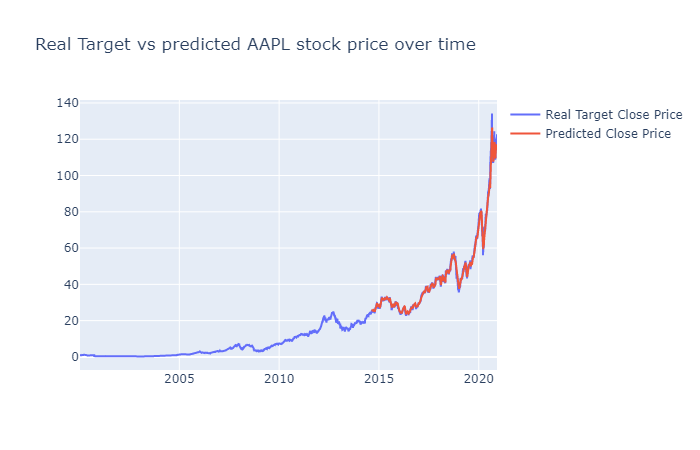

In [23]:
# Plot predictions over time
fig = px.line(title = 'Real Target vs predicted '+ stock + ' stock price over time')
fig.add_scatter(x = Supervised_data.index, y = Supervised_data['Target'],mode='lines', name = 'Real Target Close Price')
fig.add_scatter(x = Predictions_df.index, y = Predictions_df['Predictions'],mode='lines', name = 'Predicted Close Price')
fig.show("png")

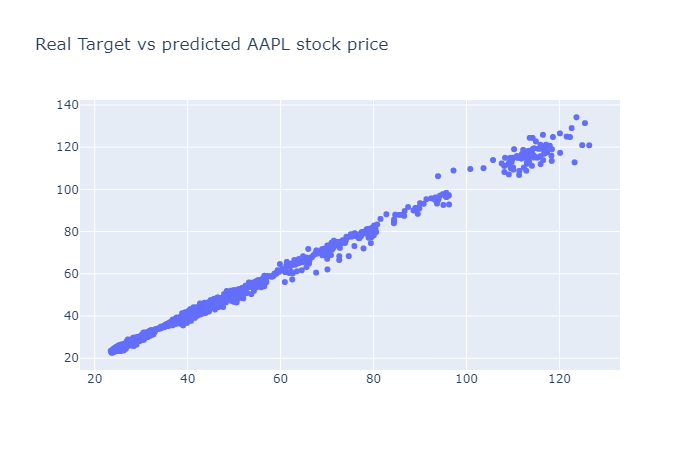

In [24]:
# Plot predictions vs target
fig = px.scatter(title = 'Real Target vs predicted '+ stock + ' stock price')
fig.add_trace(go.Scatter(x = Predictions_df['Predictions'], y = Predictions_df['Target'],mode = 'markers'))
fig.show("png")

In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
R2_score = r2_score(Predictions_df['Predictions'],Predictions_df['Target'])
MSE = mean_squared_error(Predictions_df['Predictions'],Predictions_df['Target'])
RMSE = MSE**(1/2)
MAE = mean_absolute_error(Predictions_df['Predictions'],Predictions_df['Target'])
print('R2_score is {}'.format(R2_score))
print('-'*50)
print('The mean squared error is {}'.format(MSE))
print('-'*50)
print('The root mean squared error is {}'.format(RMSE))
print('-'*50)
print('the mean absolute error is {}'.format(MAE))
print('-'*50)

R2_score is 0.99489145167632
--------------------------------------------------
The mean squared error is 2.5962745783265695
--------------------------------------------------
The root mean squared error is 1.6112959313318487
--------------------------------------------------
the mean absolute error is 0.965246310985837
--------------------------------------------------
